# ETEL

In [1]:
import numpy as np
import torch

dtype = torch.float32
dtype_np = np.float32
torch.set_default_dtype(dtype)

def simulator(T, 𝜇, 𝜎=1.0):
    N = np.size(𝜇)
    x = 𝜎 * np.random.normal(size=(N,T)) + np.atleast_2d(𝜇).T
    return x 

In [2]:
import scipy.optimize as spo
from scipy.special import logsumexp

class EE(torch.nn.Module):
    def __init__(self, D, M, K):
        super().__init__()
        self.D = D # dimensionality of each data point x_i, i=1,...,T
        self.M = M # dimensionality of model parameter 𝜃
        self.K = K # number of estimating equations
        self.layer1 = torch.nn.Linear(D+M, K)
    def forward(self, x, 𝜃):
        # x.shape = N x T x D
        # 𝜃.shape = N x     M
        x_full = torch.cat((x,𝜃.unsqueeze(-2).expand(-1,x.shape[-2],-1)),dim=-1)
        return self.layer1(x_full)
    def jacobian_pars(self, X, 𝜃):
        # X.shape     = N x T x D
        # 𝜃.shape     = N x     M
        # X_full.shape= N x T x (D+M)
        X_full = torch.cat((X,𝜃.unsqueeze(-2).expand(-1,X.shape[-2],-1)),dim=-1)
        # dGd𝜙.shape = N x T x K x dim(𝜙)
        dGdA = torch.matmul(torch.ones((*X.shape[:-1], self.K, 1)), X_full.unsqueeze(-2))
        dGdb = torch.ones((*X.shape[:-1], K, 1))
        return torch.cat((dGdA, dGdb), dim=-1)

def Φ(𝜆, G):
    𝜂 = torch.matmul(G, 𝜆.unsqueeze(-1)).squeeze(-1)
    return torch.logsumexp(𝜂, axis=-1)

def Φ_np(𝜆, G):
    𝜂 = G.dot(𝜆)    
    return logsumexp(𝜂, axis=-1)

def gradΦ(𝜆, G):
    w = torch.exp(log_w_opt(𝜆, G))
    return torch.bmm(w.unsqueeze(-2), G).squeeze(-2)

def solve_𝜆(G):
    with torch.no_grad():
        N, K = G.shape[0], G.shape[-1]
        𝜆0 = np.zeros((N, K))
        𝜆 = np.zeros_like(𝜆0)
        for i in range(N):
            def Φ_G(𝜆):
                return Φ_np(𝜆, G[i].numpy())
            𝜆[i] = spo.minimize(Φ_G, 𝜆0[i])['x']
    return torch.tensor(𝜆,dtype=dtype)

def log_w_opt(𝜆, G):
    𝜂 = torch.bmm(G, 𝜆.unsqueeze(-1)).squeeze(-1)
    return 𝜂 - torch.logsumexp(𝜂,axis=-1).unsqueeze(-1)

def log_pX𝜃(g, X, 𝜃):
    G = g(X, 𝜃)
    𝜆 = solve_𝜆(G)
    log_w = log_w_opt(𝜆, G)
    return log_w.sum(axis=-1)

def grad_log_pX𝜃(g, X, 𝜃):
    G = g(X, 𝜃)
    𝜆 = solve_𝜆(G)
    w = torch.exp(log_w_opt(𝜆, G))

    Gdiagw = G  * w.unsqueeze(-1)
    GTw = torch.bmm(w.unsqueeze(-2), G).transpose(-2,-1)

    dΦd𝜆 = gradΦ(𝜆, G)
    dFd𝜆 = torch.bmm(G.transpose(-1,-2), Gdiagw) - torch.bmm(dΦd𝜆.unsqueeze(-1), dΦd𝜆.unsqueeze(-2))

    dGd𝜙 = g.jacobian_pars(X, 𝜃)
                      
    M = torch.eye(𝜆.shape[-1]).unsqueeze(0) - torch.bmm(GTw, 𝜆.unsqueeze(-2))
    dFd𝜙 = torch.bmm(M, (dGd𝜙 * w.unsqueeze(-1).unsqueeze(-1)).sum(axis=1))
    dFd𝜙 = dFd𝜙 + torch.bmm(Gdiagw.transpose(-1,-2), (dGd𝜙 * 𝜆.unsqueeze(-2).unsqueeze(-1)).sum(axis=-2))
    d𝜆d𝜙 = torch.linalg.solve(dFd𝜆, dFd𝜙) # Inverse function theorem: d𝜆d𝜙 = inv(dFd𝜆) * dFd𝜙 

    diff  = (1. - T * w).unsqueeze(-1)
    grad = torch.bmm((diff * G).sum(axis=-2).unsqueeze(-2), d𝜆d𝜙) 
    grad = grad + torch.bmm(𝜆.unsqueeze(-2), (diff.unsqueeze(-1) * dGd𝜙).sum(axis=-3))

    return grad.squeeze(-2)

def loss_INFONCE(g, X, 𝜃):
    N = X.shape[0]
    idx = torch.arange(N)
    idx𝜃, idxX = torch.repeat_interleave(idx, N), idx.repeat(N)
    log_p_all = log_pX𝜃(g, X[idxX], 𝜃[idx𝜃]).reshape(N,N)
    log_normalizers = torch.logsumexp(log_p_all, axis=-1)
    log_p = torch.diag(log_p_all)
    return (log_p - log_normalizers).sum(axis=0)

def grad_INFONCE(g, X, 𝜃):
    N = X.shape[0]
    assert 𝜃.shape[0] == N # could untie this, but not necessary for basic usage

    idx = torch.arange(N)
    idx𝜃, idxX = torch.repeat_interleave(idx, N), idx.repeat(N)

    log_p_all = log_pX𝜃(g, X[idxX], 𝜃[idx𝜃]).reshape(N,N) # 𝜃s constant across rows, Xs constant across columns
    log_normalizers = torch.logsumexp(log_p_all, axis=-1)
    log_normalizers = torch.logsumexp(log_p_all, axis=-1)
    log_p = torch.diag(log_p_all)
    loss = (log_p - log_normalizers).sum(axis=0)

    v = (torch.eye(N) - torch.exp(log_p_all - log_normalizers.unsqueeze(-1))).unsqueeze(-1)  
    grad_log_p_all = grad_log_pX𝜃(g, X[idxX], 𝜃[idx𝜃]).reshape(N,N,-1)

    grad = (v * grad_log_p_all).sum(axis=-2).sum(axis=0)
    
    return grad, loss


In [11]:
D, M = 1, 1
K = M # use as many estimating equations as there are model parameters

g = EE(D,M,K)

# manually set estimating equations to g(x,𝜃) = x - 𝜃 such that the model fits the mean 𝜃 = E[X]
d = g.layer1.state_dict()
d['weight'] = torch.tensor([[-0.7,0.5]])
d['bias'] = torch.tensor([0.0])
g.layer1.load_state_dict(d)

<All keys matched successfully>

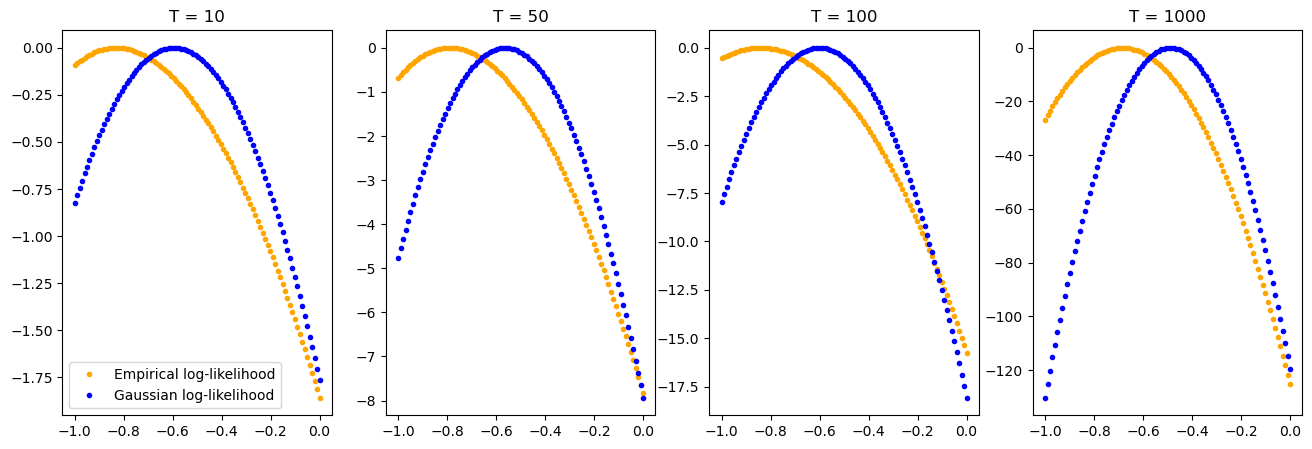

In [12]:
import matplotlib.pyplot as plt
N = 100
𝜇s = - 0.5 * np.ones(N) # np.random.normal(size=N)
𝜎= 1.0
𝜃 = torch.linspace(-1, 0, N).unsqueeze(-1) # range of test values for 𝜃

Ts = [10, 50, 100, 1000]
plt.figure(figsize=(16,5))
for i,T in enumerate(Ts):
    plt.subplot(1,len(Ts),i+1)

    X = torch.tensor(simulator(T, 𝜇=𝜇s, 𝜎=𝜎), dtype=dtype).unsqueeze(-1)
    X = X[0].unsqueeze(0).repeat(N,1,1) # fix one dataset
    ll = log_pX𝜃(g, X, 𝜃)

    # exponentially tilted empirical likelihood 
    plt.plot(𝜃.detach().numpy(), ll.detach().numpy() - ll.max().detach().numpy(), '.', color='orange', label='Empirical log-likelihood')
    # compare to true likelihood
    ll_gauss = (- 0.5 * T/𝜎**2 * (𝜃.squeeze(1) - X.mean(axis=(1,2)))**2).detach().numpy()
    plt.plot(𝜃.detach().numpy(),ll_gauss - ll_gauss.max(), '.', color='b', label='Gaussian log-likelihood') 
    if i == 0:
        plt.legend()
    plt.title("T = "+str(T))

In [13]:
N_train, T_train = 10, 1000

𝜇s_train = np.random.randn(N_train)/10. # np.random.normal(size=N)
𝜎_train = 1.0

X_train = torch.tensor(simulator(T_train, 𝜇=𝜇s_train, 𝜎=𝜎_train), dtype=dtype).unsqueeze(-1)
𝜇s_train = torch.tensor(𝜇s_train, dtype=dtype).unsqueeze(-1)

In [18]:
n_steps = 100
losses = np.zeros(n_steps)

lr = 1e-5
batch_size = 10
for i in range(n_steps):
    idx = torch.tensor(np.random.choice(N_train, batch_size, replace=False))

    grad, losses[i] = grad_INFONCE(g, X_train[idx], 𝜇s_train[idx])
    #losses[i] = log_pX𝜃(g, X_train, 𝜇s_train).sum()
    #grad = grad_log_pX𝜃(g, X_train, 𝜇s_train).sum(axis=0)

    print('step #' + str(i+1) + '/' + str(n_steps) + ', value=' + str(losses[i]))
    d = g.layer1.state_dict()
    d['weight'] += lr * grad[:2].reshape(1,2)
    d['bias'] += lr * grad[-1]
    g.layer1.load_state_dict(d)
    
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('# iter')

step #1/100, value=-16.3583984375
step #2/100, value=-16.3759765625
step #3/100, value=-16.3955078125
step #4/100, value=-16.4111328125
step #5/100, value=-16.42919921875
step #6/100, value=-16.4453125
step #7/100, value=-16.4658203125
step #8/100, value=-16.48388671875
step #9/100, value=-16.50341796875
step #10/100, value=-16.52001953125
step #11/100, value=-16.537109375
step #12/100, value=-16.5537109375
step #13/100, value=-16.56982421875
step #14/100, value=-16.59130859375
step #15/100, value=-16.607421875
step #16/100, value=-16.626953125
step #17/100, value=-16.6455078125
step #18/100, value=-16.66162109375
step #19/100, value=-16.68017578125
step #20/100, value=-16.69970703125
step #21/100, value=-16.71826171875
step #22/100, value=-16.736328125
step #23/100, value=-16.75146484375
step #24/100, value=-16.77197265625
step #25/100, value=-16.79052734375
step #26/100, value=-16.80615234375
step #27/100, value=-16.826171875
step #28/100, value=-16.84521484375
step #29/100, value=-1

_LinAlgError: torch.linalg.solve: (Batch element 0): The solver failed because the input matrix is singular.

In [19]:
d = g.layer1.state_dict()
d['weight'], d['bias']

(tensor([[-0.0040,  0.5123]]), tensor([-0.3903]))

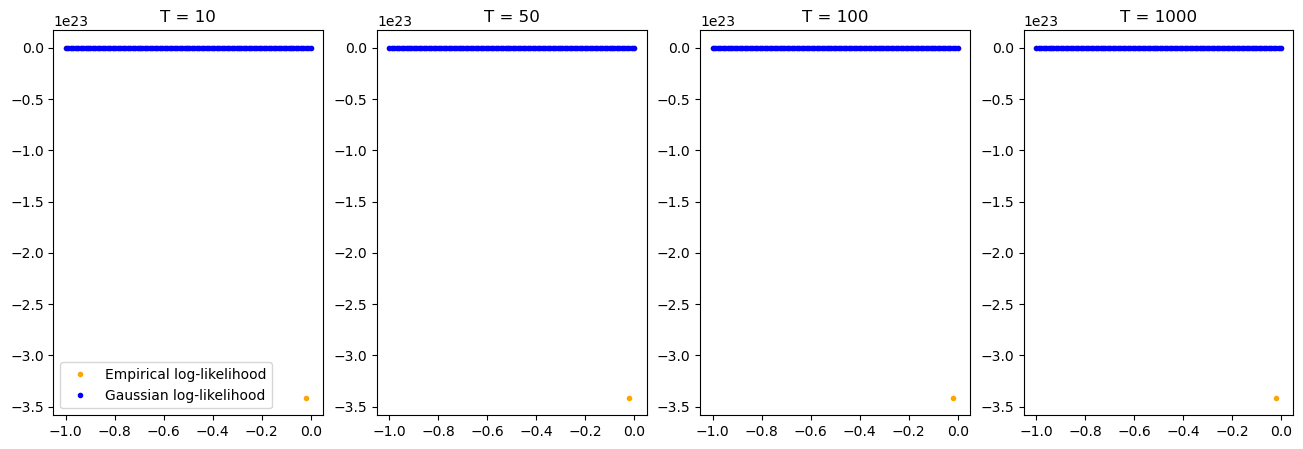

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
for i,T in enumerate(Ts):
    plt.subplot(1,len(Ts),i+1)

    ll = log_pX𝜃(g, X, 𝜃)
    # exponentially tilted empirical likelihood 
    plt.plot(𝜃.detach().numpy(), ll.detach().numpy() - ll.max().detach().numpy(), '.', color='orange', label='Empirical log-likelihood')
    # compare to true likelihood
    ll_gauss = (- 0.5 * T/𝜎**2 * (𝜃.squeeze(1) - X.mean(axis=(1,2)))**2).detach().numpy()
    plt.plot(𝜃.detach().numpy(),ll_gauss - ll_gauss.max(), '.', color='b', label='Gaussian log-likelihood') 
    if i == 0:
        plt.legend()
    plt.title("T = "+str(T))

In [ ]:
from torch.autograd.functional import jacobian

class Solver_𝜆(torch.autograd.Function):

    @staticmethod
    def forward(ctx, X, 𝜃):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        with torch.no_grad():
            G = g(X, 𝜃)
            dGd𝜙 = g.jacobian_pars(X, 𝜃)
            N, K = G.shape[0], G.shape[-1]
            𝜆0 = np.zeros((N, K))
            𝜆 = np.zeros_like(𝜆0)
            for i in range(N):
                def Φ_G(𝜆):
                    return Φ_np(𝜆, G[i].numpy())
                𝜆[i] = spo.minimize(Φ_G, 𝜆0[i])['x']
        ctx.save_for_backward(G, dGd𝜙, 𝜆)

        return torch.tensor(𝜆,dtype=dtype)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.

        g(X,𝜃)             # N x T x K
        𝜆                  # N x     K
        w                  # N x T
        gradΦ(𝜆, G)        # N x     K
        dGd𝜙               # N x T x K x dim(𝜙)

        """
        G,dGd𝜙,𝜆 = ctx.saved_tensors
        with torch.no_grad():
            w = torch.exp(log_w_opt(𝜆, G))
            dΦd𝜆 = gradΦ(𝜆, G)
            dFd𝜆 = torch.bmm(G.transpose(-1,-2), G  * w.unsqueeze(-1)) - torch.bmm(dΦd𝜆.unsqueeze(-1), dΦd𝜆.unsqueeze(-2))

            #dwd𝜙 = w * torch.matmul(dGd𝜙 - torch.matmul(dGd𝜙, w).unsqueeze(-2), 𝜆) 
            #dFd𝜙 = torch.bmm(dgd𝜙, w) + torch.matmul(dwd𝜙, G)
            dFd𝜙 = torch.bmm((G  * w.unsqueeze(-1)).transpose(-1,-2), (dGd𝜙 * 𝜆.unsqueeze(-2).unsqueeze(-1)).sum(axis=-2)) 

            d𝜆d𝜙 = torch.linalg.solve(dFd𝜆, dFd𝜙) # Inverse function theorem: d𝜆d𝜙 = inv(dFd𝜆) * dFd𝜙 
        return grad_output * d𝜆d𝜙
